# Лабораторная работа 4: Решение нелинейной краевой задачи

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import newton, root_scalar
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

In [ ]:
def solve_shooting(y0, tol=1e-8):
    """Метод стрельбы для решения краевой задачи
    
    Аргументы:
        y0 — значение y в начале отрезка (x=0)
        tol — точность для интегрирования и метода Ньютона

    Возвращает:
        x, y — массивы координат и найденного решения
    """

    # Правая часть системы, переписанная как система ОДУ 1-го порядка
    def equation(x, u):
        y, z = u
        return [z, -0.5/(1 - 0.5 * y) * z**2]

    # Целевая функция: хотим подобрать такую производную в нуле (alpha),
    # чтобы значение y(1) стало равно 0
    def objective(alpha):
        sol = solve_ivp(equation, [0, 1], [y0, alpha],
                        t_eval=[1], rtol=tol, atol=tol)
        return sol.y[0, -1]  # отклонение от граничного условия y(1)=0

    try:
        # Пробуем метод Ньютона по alpha (начальной производной)
        alpha = newton(objective, 0, tol=tol)
    except RuntimeError:
        try:
            # Если Ньютон не сходится, используем бисекцию
            result = root_scalar(objective, bracket=[-10, 10], method='brentq')
            alpha = result.root
        except:
            # В крайнем случае используем приближение
            alpha = -2 * y0  # производная противоположна y0

    # После нахождения alpha интегрируем с найденным значением
    solution = solve_ivp(equation, [0, 1], [y0, alpha],
                         t_eval=np.linspace(0, 1, 100),
                         rtol=tol, atol=tol)

    return solution.t, solution.y[0]

In [ ]:
def solve_quasilinearization(y0, max_iter=50, tol=1e-6, n=100):
    """Метод квазилинеаризации Ньютона с дискретной сеткой из n точек

    Аргументы:
        y0 — значение на левом конце (x=0)
        max_iter — максимальное число итераций
        tol — допустимая погрешность
        n — число точек сетки

    Возвращает:
        x, y — массивы координат и приближённого решения
    """

    x = np.linspace(0, 1, n)
    h = x[1] - x[0]

    # Начальное приближение: линейная интерполяция между y0 и 0
    y = y0 * (1 - x)

    for iteration in range(max_iter):
        # Производные приближаем через центральные разности
        y_prime = np.gradient(y, h, edge_order=2)
        y_dprime = np.gradient(y_prime, h, edge_order=2)

        # Правая часть уравнения
        F = y_dprime + 0.5 / (1 - 0.5 * y) * y_prime ** 2

        # Учитываем граничные условия явно
        F[0], F[-1] = y[0] - y0, y[-1]  # y(0) = y0, y(1) = 0

        # Построение якобиана (матричной системы), только для внутренних точек
        main_diag = -2 / h**2 + 0.25 * y_prime**2 / (1 - 0.5 * y)**2
        off_diag = 1 / h**2 + 0.5 * y_prime / (h * (1 - 0.5 * y))

        # Матрица Якоби собрана в разреженном формате
        diagonals = [main_diag[1:-1], off_diag[1:-1][:-1], off_diag[1:-1][:-1]]
        J = diags(diagonals, [0, -1, 1])

        # Решаем систему линейных уравнений J * delta = -F
        delta = spsolve(J, -F[1:-1])

        # Обновляем приближение
        y[1:-1] += delta

        # Проверка на сходимость
        if np.max(np.abs(delta)) < tol:
            break

    return x, y

In [ ]:
def analyze_grid_convergence(y0):
    """Анализ сходимости квазилинеаризации Ньютона"""

    print("Анализ сходимости по сетке...")
    N_values = [50, 100, 200, 400, 800, 1600, 3200]
    solutions = []

    for N in N_values:
        print("...")
        x, y = solve_quasilinearization(y0, n=N)
        solutions.append((x, y))

    # Вычисляем разности между решениями на разных сетках
    errors = []
    for i in range(len(N_values) - 1):
        x1, y1 = solutions[i]
        x2, y2 = solutions[i + 1]
        # Интерполируем более грубое решение на более точную сетку
        y1_interp = np.interp(x2, x1, y1)
        err = np.linalg.norm(y1_interp - y2, ord=np.inf)
        errors.append(err)

    # Логарифмический график погрешности
    plt.figure(figsize=(8, 5))
    plt.loglog(N_values[1:], errors, 'o-', lw=2)
    plt.title('Сходимость по расчетной сетке (метод Ньютона)')
    plt.xlabel('Число узлов N')
    plt.ylabel('Макс. ошибка между решениями')
    plt.grid(True, which="both", ls="--")
    plt.tight_layout()
    plt.show()

C:\Users\alexs\AppData\Local\Temp\ipykernel_27980\2108134232.py:40: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  delta = spsolve(J, -F[1:-1])


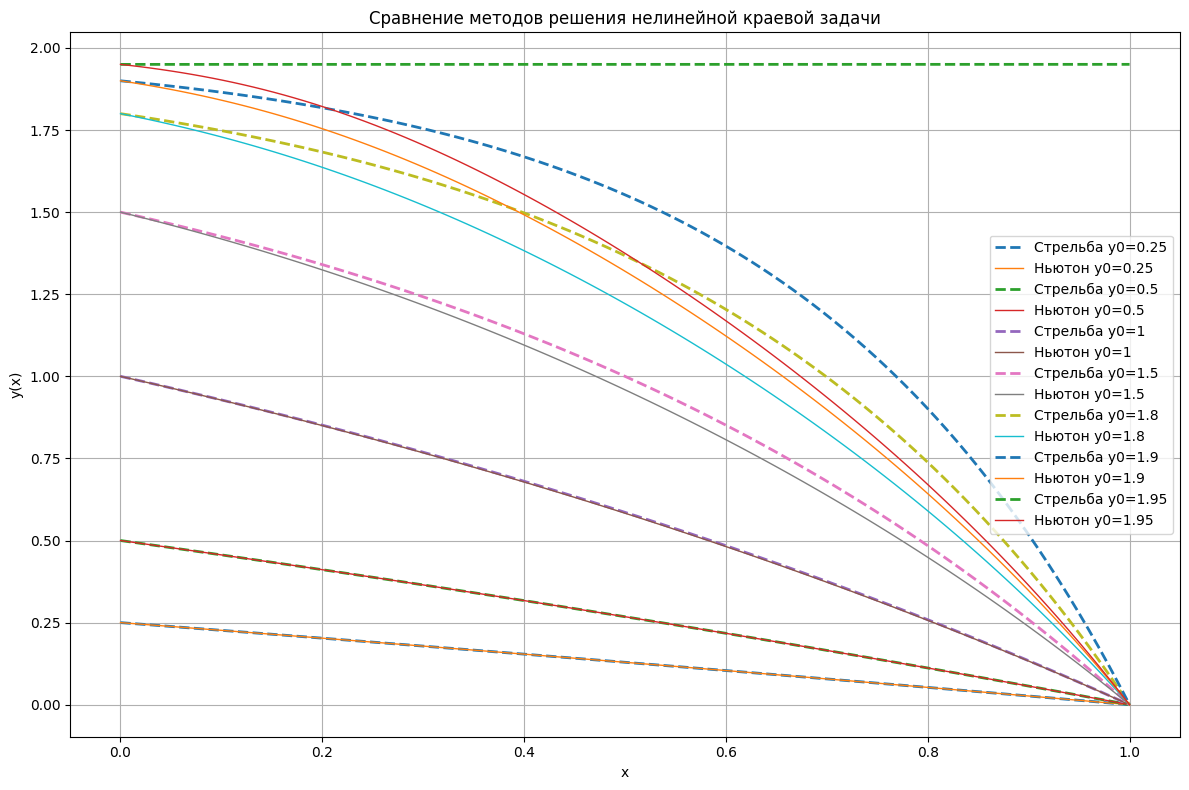

In [68]:
# Значения начального условия y(0) из условия задачи
y0_list = [0.25, 0.5, 1, 1.5, 1.8, 1.9, 1.95]

plt.figure(figsize=(12, 8))

# Перебираем разные значения y(0)
for y0 in y0_list:
    try:
        # Решение методом стрельбы
        x_shoot, y_shoot = solve_shooting(y0)
        plt.plot(x_shoot, y_shoot, '--', lw=2, label=f'Стрельба y0={y0}')

        # Решение квазилинеаризацией Ньютона
        x_ql, y_ql = solve_quasilinearization(y0)
        plt.plot(x_ql, y_ql, '-', lw=1, label=f'Ньютон y0={y0}')
    except Exception as e:
        # Ловим и выводим ошибку, если возникла
        print(f"Ошибка для y0={y0}: {str(e)}")

plt.title('Сравнение методов решения нелинейной краевой задачи')
plt.xlabel('x')
plt.ylabel('y(x)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Анализ сходимости по сетке...
...
...
...
...
...
...
...


C:\Users\alexs\AppData\Local\Temp\ipykernel_27980\2108134232.py:40: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  delta = spsolve(J, -F[1:-1])


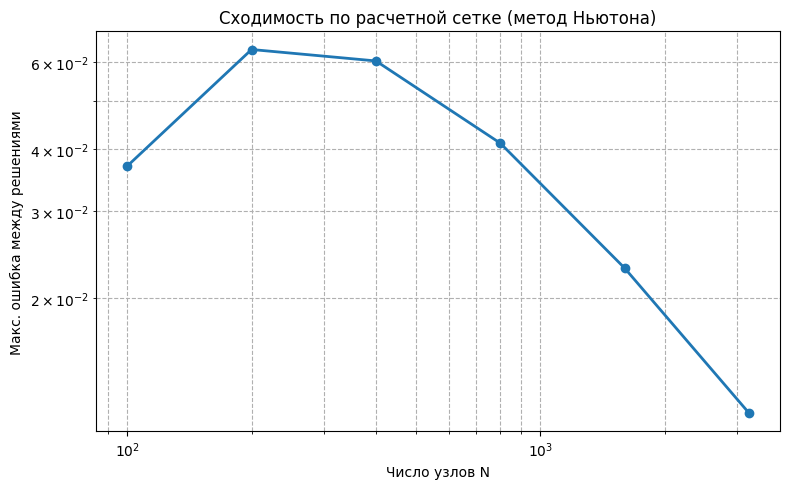

In [69]:
analyze_grid_convergence(y0=1.5)

# Вывод

Были реализованы и сравнены два численных метода решения нелинейной краевой задачи: метод стрельбы и метод квазилинеаризации Ньютона.

Метод стрельбы показал зависимость результата от начального значения производной - при неудачном выборе начального значения решение может сильно отличаться от истинного.

Метод Ньютона оказался более устойчивым и точным, при этом показал хорошую сходимость при увеличении числа узлов сетки.